<a href="https://colab.research.google.com/github/erickgrm/evolvingDeepNNs/blob/master/proyectoAP_EGR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Proyecto de Aprendizaje Profundo
## Diseño de redes neuronales mediante algoritmos genéticos
### Erick García Ramírez
Semestre 2020-1,
PCIC-UNAM

Proyecto basado en el artículo: 

[1] "Regularized Evolution for Image Classifier Architecture Search", de E. Real, A. Aggarwal y Y. Huang. ArXiv:1802.01548v7,  Feb 2019.  

Algunas secciones de la implementación usan código de:

[2] https://colab.research.google.com/github/google-research/google-research/blob/master/evolution/regularized_evolution_algorithm/regularized_evolution.ipynb


### Contenido de la presente notebook:


I. Comparación entre algoritmos genéticos

II. La aquitectura de una red neuronal

III. Evolución de la arquitectura


## I: Comparación entre algoritmos genéticos
 
El algoritmo genético en  [1] (AES). Es un algoritmo génetico muy simple, cuyos únicos mecanismos de "evolución" son la mutación y la eliminación del elemento más viejo en la población.

IMPORTANTE: la mutación en AES es tan simple que en una red la mutación cambia únicamente una conexión o una operación. Por lo tanto, al inicio la búsqueda está más basada en la explotación que en la exploración. 

Proponemos usar un nuevo algoritmo genético (EGA) cuya búsqueda al inicio está fuertemente basada en exploración. 

Comparación general entre AES y EGA:

1. AES encuentra individuos con fitness alto en menos ciclos
2. AES tiende a perder individuos de buen fitness frecuentemente, y esto significa que típicamente no halla el óptimo absoluto 
3. EGA típicamente halla el óptimo absoluto si se le permite correr por suficientes ciclos. 
4. Bajo la suposición de que deseamos explorar un gran número de modelos (>5000), EGA funciona mucho mejor que AES en el espacio de búsqueda de juguete. 
5. EGA hace uso de un cruzamiento complejo entre la población, y de mutación en más de un punto. EGA es completamente elitista, pues en cada ciclo mantiene a población más óptima vista hasta ese momento. 
6. Debido a que hay mecanismo de evolución más complejos en EGA que en AES, EGA toma más tiempo para correr.



### Implementación de EGA (Eclectic Genetic Algorithm)

In [0]:
### Routines for simulating models and their fitness: taken from [2] ###
DIM = 120  # Number of bits in the bit strings (i.e. the "models").
NOISE_STDEV = 0.01  # Standard deviation of the simulated training noise.

class Model(object): 
    def __init__(self):
        self.arch = None
        self.accuracy = None
    
    def __str__(self):
        return '{0:b}'.format(self.arch)

def train_and_eval(arch):
    accuracy =  float(_sum_bits(arch)) / float(DIM)
    accuracy += random.gauss(mu=0.0, sigma=NOISE_STDEV)
    accuracy = 0.0 if accuracy < 0.0 else accuracy
    accuracy = 1.0 if accuracy > 1.0 else accuracy
    return accuracy

def _sum_bits(arch):
    total = 0
    for _ in range(DIM):
        total += arch & 1
        arch = (arch >> 1)
    return total

import random
mutation_rate = 0.05

def random_architecture():
    return random.randint(0, 2**DIM - 1)

def mutate_arch(parent_arch):
    child_arch = parent_arch
    for i in range(int(mutation_rate*DIM)):
    # Flip the bit at a random position in `child_arch`.
        child_arch = child_arch ^ (1 << random.randint(0, DIM - 1))
  
    return child_arch

In [2]:
# New function for crossing two architectures. 
# Performs two-point crossing with string of length DIM
def crossing_arch(parent_arch1, parent_arch2):
    str1 = bin(parent_arch1)[2:]
    str2 = bin(parent_arch2)[2:]
    while len(str1) < DIM:
        str1 = '0' + str1
    while len(str2) < DIM:
        str2 = '0' + str2
    pos1 = random.randint(0,DIM)
    pos2 = random.randint(0,DIM)
    if pos2 < pos1:
        temp = pos1
        pos1 = pos2
        pos2 = temp
    
    new_str1 = str1[:pos1] + str2[pos1:pos2] + str1[pos2:]
    new_str2 = str2[:pos1] + str1[pos1:pos2] + str2[pos2:]
    
    return int(new_str1, 2), int(new_str2, 2)

# Example
x = random_architecture()
y = random_architecture()
z,w = crossing_arch(x,y)
print("Originals:", x,y)
print("After crossing:", z,w)

Originals: 346122998570966524293265854546814677 905857701583642741821889780587322305
After crossing: 346387715076515064847728801114990293 905592985078094201267426834019146689


In [0]:
# Main function that performs crossing and mutation on the whole population. 
# Returns the new evolved population. Best fitness is kept in the new population.
def cross_and_mutate_population(population, sample_size):
    partial_history = [] # Not used by the algorithm, reports all models seen
        
    sample = []
    while len(sample) < sample_size:
        sample.append(random.choice(population))
    parent = max(sample, key = lambda i: i.accuracy)
    
    child = Model()
    child.arch = mutate_arch(parent.arch)
    child.accuracy = train_and_eval(child.arch)
    partial_history.append(child)
    
    i = 0 
    while i < len(population) and child.accuracy < population[i].accuracy:
        i += 1
    if i < len(population): 
        population = population[:i] + [child] + population[i:-1]    
        
    temp = population
    # Full crossover, "Vasconcelos" crossing: worst paired with best
    while 1 < len(temp): 
        parent1 = temp[0] #max(temp, key=lambda i: i.accuracy)
        parent2 = temp[-1] #min(temp, key=lambda i: i.accuracy)
    
        # Crossover
        child1 = Model()
        child2 = Model()
        child1.arch, child2.arch = crossing_arch(parent1.arch, parent2.arch) 
        child1.accuracy = train_and_eval(child1.arch)
        child2.accuracy = train_and_eval(child2.arch)
        partial_history.append(child1)
        partial_history.append(child2)
        
        i = 0 
        while i < len(population) and child1.accuracy < population[i].accuracy:
            i += 1
        if i < len(population):
            population = population[:i] + [child1] + population[i:]
        else: population.append(child1)
            
        i = 0 
        while  i < len(population) and child2.accuracy < population[i].accuracy:
            i += 1
        if i < len(population):
            population = population[:i] + [child2] + population[i:]
        else: population.append(child2)
        
        temp = temp[1:-1]
    # END OF WHILE
    population = population[:20]
            
    return population, partial_history

In [0]:
# Routine to order thr population by fitness
def order_by_accuracy(population):
    temp = Model()
    for i in range(len(population)):
        for j in range(len(population)):
            if population[j].accuracy < population[i].accuracy:
                temp = population[i]
                population[i] = population[j]
                population[j] = temp
    return population

In [0]:
# The Eclectic Genetic Algorithm 
def eclectic_ga(cycles, population_size, sample_size):

    population = []
    history = []  # Not used by the algorithm, only used to report results.

    # Initialize the population with random models.
    while len(population) < population_size:
        model = Model()
        model.arch = random_architecture()
        model.accuracy = train_and_eval(model.arch)
        population.append(model)
        history.append(model)
    population = order_by_accuracy(population)

    # Carry out evolution in cycles.
    while len(history) < cycles:
        # Mutation and crossing
        population, partial_history = cross_and_mutate_population(population, sample_size)
        
        history = history + partial_history

    return history, population

In [6]:
# Test run
history, population = eclectic_ga(cycles = 15000, population_size = 100, sample_size = 10)
print("Maximum found by EGA over 15000 models:", population[0].accuracy)

Maximum found by EGA over 15000 models: 0.8884675065308139


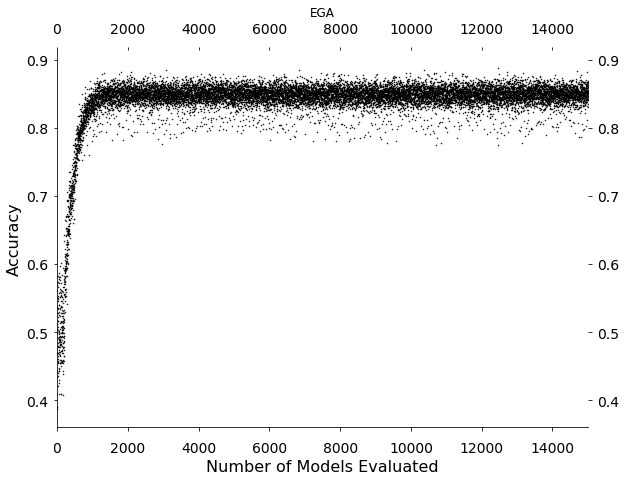

In [7]:
# Routine to plot the results of EGA, taken from [2]
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
plt.title('EGA')
sns.set_style('white')
xvalues = range(len(history))
yvalues = [i.accuracy for i in history]
ax = plt.gca()
ax.scatter(
    xvalues, yvalues, marker='.', facecolor=(0.0, 0.0, 0.0),
    edgecolor=(0.0, 0.0, 0.0), linewidth=1, s=1)
fig = plt.gcf()
fig.set_size_inches(8, 6)
fig.tight_layout()
ax.tick_params(
    axis='x', which='both', bottom='True', top='False', labelbottom='True',
    labeltop='False', labelsize=14, pad=10)
ax.tick_params(
    axis='y', which='both', left='True', right='False', labelleft='True',
    labelright='False', labelsize=14, pad=5)

plt.xlabel('Number of Models Evaluated', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xlim(0, len(history))
sns.despine()

In [0]:
# Implementation of AES, for comparison. Taken from [2]
import collections
import random

def regularized_evolution(cycles, population_size, sample_size):

  population = collections.deque()
  history = []  # Not used by the algorithm, only used to report results.

  # Initialize the population with random models.
  while len(population) < population_size:
    model = Model()
    model.arch = random_architecture()
    model.accuracy = train_and_eval(model.arch)
    population.append(model)
    history.append(model)

  # Carry out evolution in cycles. Each cycle produces a model and removes
  # another.
  while len(history) < cycles:
    # Sample randomly chosen models from the current population.
    sample = []
    while len(sample) < sample_size:
      # Inefficient, but written this way for clarity. In the case of neural
      # nets, the efficiency of this line is irrelevant because training neural
      # nets is the rate-determining step.
      candidate = random.choice(list(population))
      sample.append(candidate)

    # The parent is the best model in the sample.
    parent = max(sample, key=lambda i: i.accuracy)

    # Create the child model and store it.
    child = Model()
    child.arch = mutate_arch(parent.arch)
    child.accuracy = train_and_eval(child.arch)
    population.append(child)
    history.append(child)

    # Remove the oldest model.
    population.popleft()

  return history, population

In [9]:
#Test run
aes_history, aes_population = regularized_evolution(
    cycles=15000, population_size=100, sample_size=10)
print("Maximum found by AES over 15000 models:", max(aes_population, key=lambda i : i.accuracy).accuracy)

Maximum found by AES over 15000 models: 0.8258147560475971


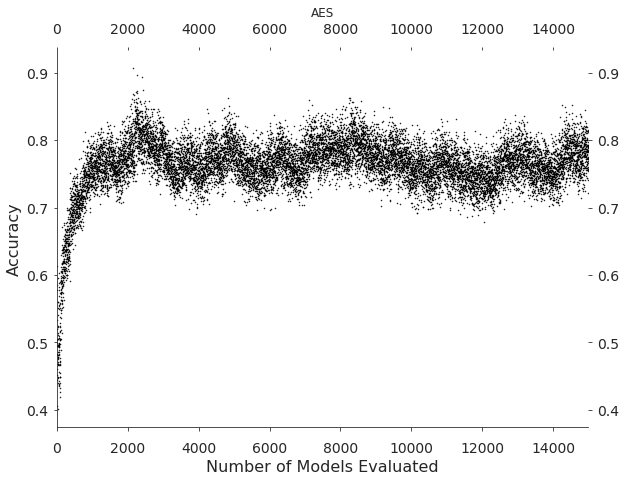

In [10]:
# Routine to plot the results of AES, taken from [2]
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
plt.title('AES')
sns.set_style('white')
xvalues = range(len(aes_history))
yvalues = [i.accuracy for i in aes_history]
ax = plt.gca()
ax.scatter(
    xvalues, yvalues, marker='.', facecolor=(0.0, 0.0, 0.0),
    edgecolor=(0.0, 0.0, 0.0), linewidth=1, s=1)
fig = plt.gcf()
fig.set_size_inches(8, 6)
fig.tight_layout()
ax.tick_params(
    axis='x', which='both', bottom='True', top='False', labelbottom='True',
    labeltop='False', labelsize=14, pad=10)
ax.tick_params(
    axis='y', which='both', left='True', right='False', labelleft='True',
    labelright='False', labelsize=14, pad=5)

plt.xlabel('Number of Models Evaluated', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xlim(0, len(aes_history))
sns.despine()

## Discusión


A EGA le toma alrededor de 3000 ciclos para alcanzar valores mayores a 0.9. Esto lo hace AES en alrededor de 2000 ciclos. Esto era esperado y refleja la naturaleza más explorativa de EGA al inicio. A partir de 4000 ciclos es claro que EGA mantiene mejores individuos que AES. 

Si nuestro interés es explorar algunos miles (>5000) de modelos, EGA lo hace mejor. Si el interés es limitar fuertemente el número de modelos vistos (y por lo tanto el tiempo de búsqueda) AES es preferible. Debajo comparamos el rendimiento promedio de AES y EGA, además de una comparación simple de su tiempo de ejecución. EGA toma entre 1.0 y 1.2 veces el tiempo que toma AES.


In [11]:
import time
from datetime import timedelta

start_time = time.time()

s = 0.0
for _ in range(1000):
    _, aes_population = regularized_evolution(cycles=4000, population_size=100, sample_size=10)
    s += max(aes_population, key=lambda i: i.accuracy).accuracy
print(s/1000)

elapsed_time_secs = time.time() - start_time

msg = "Execution of 1000 x AES took: %s (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs))

print(msg)   

start_time = time.time()

s = 0.0
for _ in range(1000):
    _, population = eclectic_ga(cycles=4000, population_size=100, sample_size=10)
    s += population[0].accuracy 
print(s/1000)

elapsed_time_secs = time.time() - start_time

msg = "Execution of 1000 x EGA took: %s (Wall clock time)" % timedelta(seconds=round(elapsed_time_secs))

print(msg)    

0.825216274763601
Execution of 1000 x AES took: 0:02:37 (Wall clock time)
0.9029719686910702
Execution of 1000 x EGA took: 0:01:38 (Wall clock time)


# II:  La aquitectura de una red neuronal

En esta sección describimos e implementamos la codificación de las redes sugerida en [1]. El código usado para [2] no fue publicado, así que lo siguiente es una interpretación e implementación directa del autor. Los detalles conceptuales sobre los elementos debajo se pueden consultar en [2].

## Architecture of an AmoebaNet

The full architecture of the net is given simply by the structure of normal and reduction cells. After these are fixed, the net consists of: 

1. Input Layer
2. Conv2D 3x3, filters = 24, stride = 2
3. 2 x Reduction cell
4. Block of 3 Normal cells
5. Reduction cell
6. Block of 3 Normal cells
7. Reduction cell
8. Block of 3 Normal cells
(Flatten or Global Pooling)
9. Softmax

## Representation of a cell

A cell is determined by an array o 28 integers. 

A cell can be conceptualized as 5 nodes. Each node consists of two parallel operations and has two inputs and one single output. There is a sinlge output from the whole cell. As input, each cells receives the last cell output and a residue from the one-before-last cell. 

Encoding of a cell: Node1 + Node2 + Node3 + Node4 + Node5

## Binary encoding of nodes and cells 
Since the only difference between normal and reduction cells is the size reduction in the latter, we encode both types of cells the same way. 

EGA does not work well with arbitrary integers and it is preferred to work with binary strings. We give the precise encoding of the nodes in a cell as binary strings.
    
* Node1: 8 bits, 3 for Operation1, 3 for Operation2, 1 for which operation is applied to input0, and 1 for which operation is applied to input1
* Node2: 12 bits, 6 for operations, 2 for the application of ops to inputs, 2 for choosing input from the previous 3 inputs (the two original inputs and the output of Node1) 
* Node3: 12 bits: same as Node2 but the last four bits are to choose inputs from the four previous outputs.
* Node4: 14 bits: same as Node3 but the last 6 bits are to choose inputs from the five previous outputs
* Node5: 14 bits: same as Node4 

Length of encoding of a cell: 60 bits

## GENOME
A genome is simply the encoding of the structure of the normal and reduction cells.

GENOME = code of Normal cells + code of Reduction Cells
        
Length of GENOME = 120 bits

## Operations:
0. Identity
1. SepConv 3x3
2. SepConv 5x5
3. SepConv 7x7
4. AvgPool 3x3
5. MaxPool 3x3
6. SepDilConv 3x3

## Examples
CELL = arrays of 28 digits 3210240121241130240120241043

Bin Encoding of CELL = string of length 60 011010100101000110010101001111000101000101000001010010100011

ARCH = arrays of 56 digits 3210240121241130240120241043 + 3210240121241130240120241043

Bin Encoding of ARCH = string of length 120
011010100101000110010101001111000101000101000001010010100011011010100101000110010101001111000101000101000001010010100011

In [0]:
# Routines for encoding and decoding architectures

# Auxiliary routines to turn integers into binary strings
def bin1(num):
    return bin(num)[2:]
    
def bin2(num):
    st = bin(num)[2:]
    if len(st) == 2:
        return st
    else:
        return '0' + st
    
def bin3(num):
    st = bin(num)[2:]
    while len(st) < 3:
        st = '0' + st
    return st


In [0]:
# From cell (28 digits) to binary encoding
def cell_to_encoding(cell):
    # cell is an array of 28 integers
    enconding = ''
    #Node 1
    encoding =  bin3(cell[0]) + bin3(cell[1]) + bin1(cell[2]) + bin1(cell[3])
    #Node 2
    if 2 < int(cell[8]): cell[8] = random.randint(0,3)
    if 2 < int(cell[9]): cell[9] = random.randint(0,3)
    encoding += bin3(cell[4]) + bin3(cell[5]) + bin1(cell[6]) + bin1(cell[7]) + bin2(cell[8]) + bin2(cell[9])
    #Node 3
    encoding += bin3(cell[10]) + bin3(cell[11]) + bin1(cell[12]) + bin1(cell[13]) + bin2(cell[14]) + bin2(cell[15])
    #Node 4
    encoding +=  bin3(cell[16]) + bin3(cell[17]) + bin1(cell[18]) + bin1(cell[19])
    if 4 < int(cell[20]): cell[20] = random.randint(0,5)
    if 4 < int(cell[21]): cell[21] = random.randint(0,5)
    encoding += bin3(cell[20]) + bin3(cell[21])
    #Node 5
    encoding +=  bin3(cell[22]) + bin3(cell[23]) + bin1(cell[24]) + bin1(cell[25])
    if 4 < int(cell[26]): cell[26] = random.randint(0,5)
    if 4 < int(cell[27]): cell[27] = random.randint(0,5)
    encoding += bin3(cell[26]) + bin3(cell[27])
    
    return encoding # the binary string encoding the cell

# From binary encoding to cell
import random
def encoding_to_cell(encoding):
    #encoding is a string of length 60
    cell = []
    #Node 1
    cell += [int(encoding[0:3],2)] + [int(encoding[3:6],2)] + [int(encoding[6],2)] + [int(encoding[7],2)]
    #Node 2
    cell += [int(encoding[8:11],2)] + [int(encoding[11:14],2)] + [int(encoding[14],2)] + [int(encoding[15],2)]
    o1 = int(encoding[16:18],2)
    o2 = int(encoding[18:20],2)
    if 2 < o1: cell += [random.randint(0,3)]
    else: cell += [o1] 
    if 2 < o2: cell += [random.randint(0,3)]
    else: cell += [o2]
    #Node 3
    cell += [int(encoding[20:23],2)] + [int(encoding[23:26],2)] + [int(encoding[26],2)] + [int(encoding[27],2)]
    cell += [int(encoding[28:30],2)] + [int(encoding[30:32],2)]
    #Node 4
    cell += [int(encoding[32:35],2)] + [int(encoding[35:38],2)] + [int(encoding[38],2)] + [int(encoding[39],2)]
    o1 = int(encoding[40:43],2)
    o2 = int(encoding[43:46],2)
    if 4 < o1: cell += [random.randint(0,5)]
    else: cell += [o1] 
    if 4 < o2: cell += [random.randint(0,5)]
    else: cell += [o2]
    #Node 5
    cell += [int(encoding[46:49],2)] + [int(encoding[49:52],2)] + [int(encoding[52],2)] + [int(encoding[53],2)]
    o1 = int(encoding[54:57],2)
    o2 = int(encoding[57:60],2)
    if 4 < o1: cell += [random.randint(0,5)]
    else: cell += [o1] 
    if 4 < o2: cell += [random.randint(0,5)]
    else: cell += [o2]
        
    return cell # the cell represented by the encoding

In [14]:
# General routines for swaping encodings and architectures
def arch_to_arch_encoding(arch):
    # arch is an int array of length 56, the full encoding of a net
    return cell_to_encoding(arch[0:28]) + cell_to_encoding(arch[28:56])

def arch_encoding_to_arch(arch_encoding):
    # arch_encoding is a binary string of length 120 
    return encoding_to_cell(arch_encoding[0:60]) +encoding_to_cell(arch_encoding[60:120])

# Example
arch_example = list(map(int,'32102401212411302401202410433210240121241130240120241043'))
print("Architecture example", arch_example)
arch_encoding = arch_to_arch_encoding(arch_example)
print("Architectute encoding", arch_encoding, "lengh", len(arch_encoding))
reencoded_arch = arch_encoding_to_arch(arch_encoding)
print("Reeconstructed architecture", reencoded_arch)

Architecture example [3, 2, 1, 0, 2, 4, 0, 1, 2, 1, 2, 4, 1, 1, 3, 0, 2, 4, 0, 1, 2, 0, 2, 4, 1, 0, 4, 3, 3, 2, 1, 0, 2, 4, 0, 1, 2, 1, 2, 4, 1, 1, 3, 0, 2, 4, 0, 1, 2, 0, 2, 4, 1, 0, 4, 3]
Architectute encoding 011010100101000110010101001111000101000101000001010010100011011010100101000110010101001111000101000101000001010010100011 lengh 120
Reeconstructed architecture [3, 2, 1, 0, 2, 4, 0, 1, 2, 1, 2, 4, 1, 1, 3, 0, 2, 4, 0, 1, 2, 0, 2, 4, 1, 0, 4, 3, 3, 2, 1, 0, 2, 4, 0, 1, 2, 1, 2, 4, 1, 1, 3, 0, 2, 4, 0, 1, 2, 0, 2, 4, 1, 0, 4, 3]


## The keras model represented by an architecture
Given an array of 56 digits (as far a it represents a valid AmoebaNet) we generate the actual neural network (a keras model) 

In [0]:
import tensorflow as tf
import tensorflow.keras as ks
import numpy as np

In [0]:
# Routine to choose one of the 7 allowed operations (keras layers)
def chosen_operation(n, no_filters = 24):
    layer = ks.models.Sequential()
    if n == 0:
        layer.add(ks.layers.Dense(units = 32, activation=('linear')))
    if n == 1:
        layer.add(ks.layers.SeparableConv2D(filters=no_filters, kernel_size=3, padding='same'))
    if n == 2:
        layer.add(ks.layers.SeparableConv2D(filters=no_filters, kernel_size=5, padding='same'))
    if n == 3:
        layer.add(ks.layers.SeparableConv2D(filters=no_filters, kernel_size=5, padding='same'))
    if n == 4:
        layer.add(ks.layers.AveragePooling2D(pool_size=(3,3), padding='same'))
    if n == 5:
        layer.add(ks.layers.MaxPooling2D(pool_size=(3,3), padding='same'))
    if n == 6: 
        layer.add(ks.layers.Conv2D(filters=no_filters, kernel_size=(3,3), padding='same', dilation_rate=(3, 3)))
        
    return layer

In [0]:
# Routine to generate the keras model corresponding to a cell

# Extremely simplified model. Attempts to introduce skip-connections and conditional execution failed. 
def nncell(cell_arch, filters = 24):
    cell = ks.models.Sequential()
    cell.add(chosen_operation(cell_arch[0], filters))
    cell.add(chosen_operation(cell_arch[4], filters))
    cell.add(chosen_operation(cell_arch[10], filters))
    cell.add(chosen_operation(cell_arch[16], filters))
    cell.add(chosen_operation(cell_arch[22], filters))
    return cell

### Failed attempt to introduce skip-connections and conditional execution
#def nncell(x_last, x_skip, cell_arch):
#    outputs = np.zeros(6)
#    outputs[0] = x_last
#    outputs[1] = x_skip
#    # First node in amoeba, first 4 entries
#    if cell_arch[2] == 0:
#        outputs[2] = chosen_operation(cell_arch[0], x_last)
#    else: outputs[2] = chosen_operation(cell_arch[1], x_last)
#    if cell_arch[3] == 0:
#        outputs[2] += chosen_operation(cell_arch[0], x_skip)
#    else: outputs[2] += chosen_operation(cell_arch[1], x_skip)
#         
#    # Second node in amoeba, following 6 entries
#    chosen_inp1 = cell_arch[8]
#    chosen_inp2 = cell_arch[9]
#    
#    if cell_arch[6] == 0:
#        outputs[3] = chosen_operation(cell_arch[4], outputs[chosen_inp1])
#    else: outputs[3] = chosen_operation(cell_arch[5], outputs[chosen_inp1])
#    if cell_arch[7] == 0:
#        outputs[3] += chosen_operation(cell_arch[4], outputs[chosen_inp2])
#    else: outputs[3] += chosen_operation(cell_arch[5], outputs[chosen_inp2])
#    
#    # Third node in amoeba, following 6 entries 
#    chosen_inp1 = cell_arch[14]
#    chosen_inp2 = cell_arch[15]
#    
#    if cell_arch[12] == 0:
#        outputs[4] = chosen_operation(cell_arch[10], outputs[chosen_inp1])
#    else: outputs[4] = chosen_operation(cell_arch[11], outputs[chosen_inp1])
#    if cell_arch[13] == 0:
#        outputs[4] += chosen_operation(cell_arch[10], outputs[chosen_inp2])
#    else: outputs[4] += chosen_operation(cell_arch[11], outputs[chosen_inp2])
#    
#    # Fourth node in amoeba, following 6 entries 
#    chosen_inp1 = cell_arch[20]
#    chosen_inp2 = cell_arch[21]
#    
#    if cell_arch[18] == 0:
#        outputs[5] = chosen_operation(cell_arch[16], outputs[chosen_inp1])
#    else: outputs[5] = chosen_operation(cell_arch[17], outputs[chosen_inp1])
#    if cell_arch[19] == 0:
#        outputs[5] += chosen_operation(cell_arch[16], outputs[chosen_inp2])
#    else: outputs[5] += chosen_operation(cell_arch[17], outputs[chosen_inp2])
#    
#    # Fifth node in amoeba, last 6 entries
#    chosen_inp1 = cell_arch[26]
#    chosen_inp2 = cell_arch[27]
#    
#    if cell_arch[24] == 0:
#        outputs[6] = chosen_operation(cell_arch[22], outputs[chosen_inp1])
#    else: outputs[6] = chosen_operation(cell_arch[23], outputs[chosen_inp1])
#    if cell_arch[25] == 0:
#        outputs[6] += chosen_operation(cell_arch[22], outputs[chosen_inp2])
#    else: outputs[6] += chosen_operation(cell_arch[23], outputs[chosen_inp2])
#    
#    return outputs[6] # final output of cell

In [0]:
# Recover the actual keras model from an architecture
def amoebaNet(arch, N = 3, F = 24):
    
    model = ks.models.Sequential()
    normal_cell = nncell(arch[:28])
    reduction_cell = nncell(arch[28:])
    reduction_cell.add(ks.layers.AveragePooling2D(pool_size=(2, 2), 
                                                  strides=None, padding='same'))
    
    ### Start of amoebaNet ###
    # Initial convolution
    model.add(ks.layers.Conv2D(filters=F, kernel_size=3,
                               strides=(2,2), padding='same'))
    
    # 2 Reduction cells
    model.add(reduction_cell)
    model.add(reduction_cell)
    
    # Block of N normal cells
    for _ in range(N):
        model.add(normal_cell)
    
    # 1 Reduction cell
    model.add(reduction_cell)
    
    # Block of N normal cells
    for _ in range(N):
        model.add(normal_cell)
    
    # 1 Reduction cell
    model.add(reduction_cell)
    
    # Block of N normal cells
    for _ in range(N):
        model.add(normal_cell)
    
    # Classification layer. 
    # Classification over 10 categories (MNIST-Fashion or CIFAR-10)
    model.add(ks.layers.Flatten())
    model.add(ks.layers.Dense(units=10, activation = ('softmax'))) 
    
    return model

In [0]:
# Fitness functions. Includes compilation, fitting and evaluation of accuracy 
# over the test set. The latter is the fitness of an architecture
def net_train_and_eval(arch):
    model = amoebaNet(arch)
    # Compile model
    model.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
    trained = model.fit(train_dataset, epochs=10,
                          steps_per_epoch=np.ceil(train_size/BATCH_SIZE))
    _, test_acc = model.evaluate(test_dataset_batched, steps=np.ceil(test_size/BATCH_SIZE))
    return test_acc

# Testing with MNIST-Fashion

In [20]:
# Loading  and preparation of the dataset
import tensorflow_datasets as tfds
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True) 
train_dataset, test_dataset = dataset['train'], dataset['test']
# Size of training and test sets
train_size = metadata.splits['train'].num_examples
test_size = metadata.splits['test'].num_examples
# Normalise data
def minmaxScaling(images, labels):
    images = tf.cast(images, tf.float32)
    images = images/255
    return images, labels

train_dataset = train_dataset.map(minmaxScaling)
test_dataset = test_dataset.map(minmaxScaling)
print("Number of training examples", train_size)
print("Number of testing examples", test_size)

# Shuffling and batching of training set 
BATCH_SIZE = 50
train_dataset = train_dataset.repeat().shuffle(train_size).batch(BATCH_SIZE)
# Batching of testing set
test_dataset_batched = test_dataset.batch(BATCH_SIZE)

Number of training examples 60000
Number of testing examples 10000


In [0]:
# Evaluation of example
arch = list(map(int,'32102401212411302401202410433210240121241130240120241043')) #an architecture
#net_train_and_eval(arch)


In [22]:
s = arch_to_arch_encoding(arch)
net_train_and_eval(arch_encoding_to_arch(s))

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Train on 1200.0 steps
Epoch 1/10
1200/1200 [==============================] - 158s 131ms/step - loss: 1.0341 - acc: 0.6161
Epoch 2/10
1200/1200 [==============================] - 147s 122ms/step - loss: 0.6640 - acc: 0.7601
Epoch 3/10
1200/1200 [==============================] - 144s 120ms/step - loss: 0.6023 - acc: 0.7861
Epoch 4/10
1200/1200 [==============================] - 144s 120ms/step - loss: 0.5708 - acc: 0.7982
Epoch 5/10
1200/1200 [==============================] - 143s 119ms/step - loss: 0.5375 - acc: 0.8095
Epoch 6/10
1200/1200 [==============================] - 144s 120ms/step - loss: 0.5293 - acc: 0.8116
Epoch 7/10
1200/1200 [==============================] - 144s 120ms/step - loss: 0.5088 - acc: 0.8206
Epoch 8/10
1200/1200 [==============================] - 145s 121ms/step - loss: 0.5000 - acc: 0.8248
Epoch 9/10
1200/1200 [==============================] - 145s 121ms/step - loss: 0.4882 - acc: 0.8296
Epoch 10/10
200/200 [==============================] - 11s 56ms/step 

0.8163

# III. Evolution of architectures

A model is represented by an architecture (an array of 56 digits); an architecture is encoded as a binary string of length 120. 
We apply EGA under such conditions. 

In [0]:
def cell_random_architecture():
    encoding = []
    # Node 1
    encoding += [random.randint(0,7), random.randint(0,7), random.randint(0,2), 
                 random.randint(0,2)]
    # Node 2
    encoding += [random.randint(0,7), random.randint(0,7), random.randint(0,2), 
                 random.randint(0,2), random.randint(0,3), random.randint(0,3)]
    # Node 3 
    encoding += [random.randint(0,7), random.randint(0,7), random.randint(0,2), 
                 random.randint(0,2), random.randint(0,4), random.randint(0,4)]
    # Node 4
    encoding += [random.randint(0,7), random.randint(0,7), random.randint(0,2), 
                 random.randint(0,2), random.randint(0,5), random.randint(0,5)]
    # Node 5
    encoding += [random.randint(0,7), random.randint(0,7), random.randint(0,2), 
                 random.randint(0,2), random.randint(0,5), random.randint(0,5)]
    return encoding

def net_random_architecture():
    return np.concatenate((cell_random_architecture(), cell_random_architecture()),axis=0)

# Modified Eclectic Genetic Algorithm. 
# There are only two changes: the fitness function (now is the test accuracy of the model)
# and the generation of random architectures
def net_eclectic_ga(cycles, population_size, sample_size):

    population = []
    history = []  # Not used by the algorithm, only used to report results.

    # Initialize the population with random models.
    while len(population) < population_size:
        model = Model()
        model.arch = net_random_architecture() # changed
        model.accuracy = net_train_and_eval(model.arch) # changed
        population.append(model)
        history.append(model)
    population = order_by_accuracy(population)

    # Carry out evolution in cycles.
    while len(history) < cycles:
        # Mutation and crossing
        population, partial_history = cross_and_mutate_population(population, sample_size)
        
        history = history + partial_history

    return history, population

In [0]:
# Evolution of architectures
history, population = net_eclectic_ga(cycles = 50, population_size = 10, sample_size = 4) 

Train on 1200.0 steps
Epoch 1/10
1200/1200 [==============================] - 42s 35ms/step - loss: 2.0406 - acc: 0.1980
Epoch 2/10
1200/1200 [==============================] - 30s 25ms/step - loss: 1.8353 - acc: 0.3120
Epoch 3/10
1200/1200 [==============================] - 30s 25ms/step - loss: 1.5246 - acc: 0.4431
Epoch 4/10
1200/1200 [==============================] - 30s 25ms/step - loss: 1.3183 - acc: 0.5064
Epoch 5/10
1200/1200 [==============================] - 30s 25ms/step - loss: 1.2278 - acc: 0.5549
Epoch 6/10
1200/1200 [==============================] - 31s 26ms/step - loss: 1.1797 - acc: 0.5756
Epoch 7/10
1200/1200 [==============================] - 30s 25ms/step - loss: 1.1431 - acc: 0.5848
Epoch 8/10
1200/1200 [==============================] - 30s 25ms/step - loss: 1.1343 - acc: 0.5872
Epoch 9/10
1200/1200 [==============================] - 30s 25ms/step - loss: 1.0942 - acc: 0.6038
Epoch 10/10
200/200 [==============================] - 4s 18ms/step - loss: 1.0720 - ac

In [0]:
print("Maximum test_accuracy found by net_eclectic_ga over 50 models:", max(population, key=lambda i : i.accuracy).accuracy)

In [0]:
# Plot the results of net_ecletic_ga
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
plt.title('net_eclectic_ga')
sns.set_style('white')
xvalues = range(len(history))
yvalues = [i.accuracy for i in history]
ax = plt.gca()
ax.scatter(
    xvalues, yvalues, marker='.', facecolor=(0.0, 0.0, 0.0),
    edgecolor=(0.0, 0.0, 0.0), linewidth=1, s=1)
fig = plt.gcf()
fig.set_size_inches(8, 6)
fig.tight_layout()
ax.tick_params(
    axis='x', which='both', bottom='True', top='False', labelbottom='True',
    labeltop='False', labelsize=14, pad=10)
ax.tick_params(
    axis='y', which='both', left='True', right='False', labelleft='True',
    labelright='False', labelsize=14, pad=5)

plt.xlabel('Number of Models Evaluated', fontsize=16)
plt.ylabel('Test Accuracy', fontsize=16)
plt.xlim(0, len(history))
sns.despine()

In [0]:
# Best model
best = amoebaNet(arch_encoding_to_arch(population[0]))
# Train further
best.compile(loss='sparse_categorical_crossentropy', optimizer = 'adam', metrics=['accuracy'])
best.fit(train_dataset, epochs=10, steps_per_epoch=np.ceil(train_size/BATCH_SIZE))

_, test_acc = model.evaluate(test_dataset_batched, steps=np.ceil(test_size/BATCH_SIZE))
print(test_acc)